In [1]:
import pandas as pd
import datetime
import numpy as np
from mido import Message, MidiFile, MidiTrack, MetaMessage
from collections import namedtuple

## Data processing: 

In [3]:
df = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv')
df

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source
0,Afghanistan,AFG,Asia,38928341,cases,0,2020-01,NaN,0,"Epidemic intelligence, national weekly data"
1,Afghanistan,AFG,Asia,38928341,cases,0,2020-02,0.000000,0,"Epidemic intelligence, national weekly data"
2,Afghanistan,AFG,Asia,38928341,cases,0,2020-03,0.000000,0,"Epidemic intelligence, national weekly data"
3,Afghanistan,AFG,Asia,38928341,cases,0,2020-04,0.000000,0,"Epidemic intelligence, national weekly data"
4,Afghanistan,AFG,Asia,38928341,cases,0,2020-05,0.000000,0,"Epidemic intelligence, national weekly data"
...,...,...,...,...,...,...,...,...,...,...
35541,Zimbabwe,ZWE,Africa,14862927,deaths,209,2021-32,35.390068,4109,"Epidemic intelligence, national weekly data"
35542,Zimbabwe,ZWE,Africa,14862927,deaths,140,2021-33,23.481243,4249,"Epidemic intelligence, national weekly data"
35543,Zimbabwe,ZWE,Africa,14862927,deaths,152,2021-34,19.646198,4401,"Epidemic intelligence, national weekly data"
35544,Zimbabwe,ZWE,Africa,14862927,deaths,81,2021-35,15.676589,4482,"Epidemic intelligence, national weekly data"


In [4]:
df['date'] = pd.to_datetime([datetime.datetime.strptime(d + '-1', '%G-%V-%u') for d in df['year_week']])

In [5]:
df_cases = df.loc[df['indicator'] == 'cases', ['country', 'country_code', 'date', 'weekly_count', 'cumulative_count']].rename(columns = {
    'weekly_count': 'weekly_cases', 
    'cumulative_count': 'cumulative_cases'
})

In [6]:
df_deaths = df.loc[df['indicator'] == 'deaths', ['country', 'country_code', 'date', 'weekly_count', 'cumulative_count']].rename(columns = {
    'weekly_count': 'weekly_deaths', 
    'cumulative_count': 'cumulative_deaths'
})

In [7]:
df_weekly = pd.merge(df_cases, df_deaths, on=['country', 'country_code', 'date'])
df_weekly

,country,country_code,date,weekly_cases,cumulative_cases,weekly_deaths,cumulative_deaths
0,Afghanistan,AFG,2019-12-30,0,0,0,0
1,Afghanistan,AFG,2020-01-06,0,0,0,0
2,Afghanistan,AFG,2020-01-13,0,0,0,0
3,Afghanistan,AFG,2020-01-20,0,0,0,0
4,Afghanistan,AFG,2020-01-27,0,0,0,0
...,...,...,...,...,...,...,...
17768,Zimbabwe,ZWE,2021-08-09,3761,120088,209,4109
17769,Zimbabwe,ZWE,2021-08-16,2564,122652,140,4249
17770,Zimbabwe,ZWE,2021-08-23,1785,124437,152,4401
17771,Zimbabwe,ZWE,2021-08-30,1113,125550,81,4482


In [9]:
%load_ext rpy2.ipython

[1] 15
[1] 15
`summarise()` has grouped output by 'vaccination_status'. You can override using the `.groups` argument.


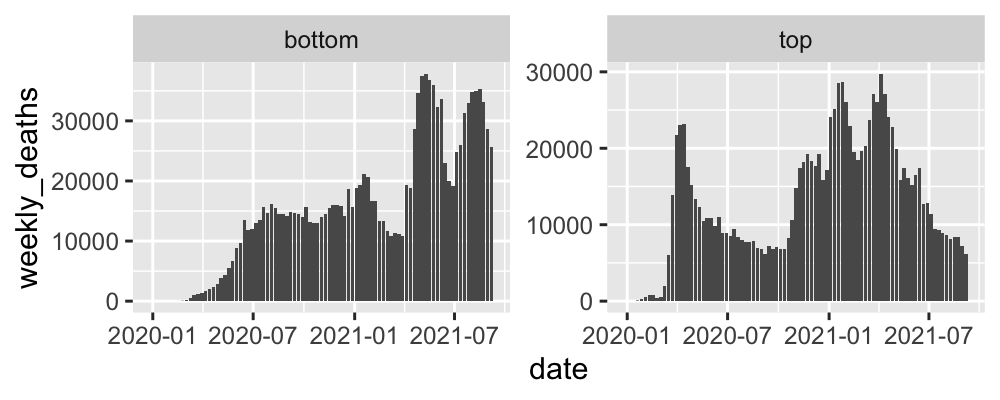

In [19]:
%%R -i df_weekly -w 5 -h 2 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

# install.packages("dplyr", repos='http://cran.us.r-project.org', quiet=TRUE)

top_countries <- c('United Arab Emirates', 'Portugal', 'Spain', 'Singapore', 'Uruguay', 'Denmark', 'Chile', 'China', 
                   'Canada', 'Ireland', 'Finland', 'France', 'Italy', 'United Kingdom', 'Brazil')
bottom_countries <- c('Tanzania', 'Nigeria', 'Ethiopia', 'Kenya', 'Egypt', 'Bangladesh', 'South Africa', 'Pakistan', 
                      'Vietnam', 'Indonesia', 'Russia', 'Iran', 'Thailand', 'India', 'Mexico')

print(length(top_countries))
print(length(bottom_countries))

pacman::p_load(ggplot2, tidyr, dplyr)
df_weekly %>%
    mutate(vaccination_status = case_when(country %in% top_countries ~ 'top', 
                                          country %in% bottom_countries ~ 'bottom',  
                                          T ~ 'discard')) %>%
    filter(vaccination_status != 'discard') %>%
    group_by(vaccination_status, date) %>%
    summarise(weekly_deaths = sum(weekly_deaths)) %>%
    ggplot(aes(x=date, y=weekly_deaths)) + geom_col() + facet_wrap(~vaccination_status, scales = 'free_y')

In [21]:
continent_names_df = pd.read_csv(
    '~/Dropbox (BBC)/Visual Journalism/Data/2020/vjdata.26866.global.covid.interactive/\
derived/bbc_world_v2_4326_centroid_region.csv'
)

continent_df = pd.merge(df_weekly, 
         continent_names_df[['iso3', 'bbc-region-code']], 
         left_on = 'country_code', 
         right_on = 'iso3').groupby(
    ['date', 'bbc-region-code']
)[['weekly_cases', 'weekly_deaths']].sum().reset_index()

def rename_continent(bbc_region): 
    switcher = {
        'region_as': 'Asia',
        'region_af': 'Africa',
        'region_am_na': 'North America',
        'region_am_lac': 'Latin America',
        'region_me': 'Middle East',
        'region_eu': 'Europe',
        'region_oc': 'Oceania'
    }
    return switcher[bbc_region]

continent_df['continent_name'] = continent_df['bbc-region-code'].map(rename_continent)
continent_df = continent_df[['date', 'continent_name', 'weekly_cases', 'weekly_deaths']]

continent_df = continent_df.sort_values(by = ['continent_name', 'date']).reset_index(drop=True)
# continent_df['cases_rolling_average'] = continent_df.groupby(
#     'continent_name'
# ).rolling(7)['cases'].mean().reset_index(drop=True)
# continent_df['deaths_rolling_average'] = continent_df.groupby(
#     'continent_name'
# ).rolling(7)['deaths'].mean().reset_index(drop=True)
continent_df['cumulative_deaths'] = continent_df.groupby(['continent_name'])['weekly_deaths'].cumsum()

In [22]:
continent_df

,date,continent_name,weekly_cases,weekly_deaths,cumulative_deaths
0,2019-12-30,Africa,0,0,0
1,2020-01-06,Africa,0,0,0
2,2020-01-13,Africa,0,0,0
3,2020-01-20,Africa,0,0,0
4,2020-01-27,Africa,0,0,0
...,...,...,...,...,...
506,2021-04-19,Oceania,1130,12,1324
507,2021-04-26,Oceania,858,16,1340
508,2021-05-03,Oceania,1231,9,1349
509,2021-05-10,Oceania,1883,16,1365


In [23]:
Note = namedtuple('Note', ['pitch', 'duration', 'accent'])
Note.__new__.__defaults__ = (None,) * len(Note._fields)
Part = namedtuple('Part', 'notes')
Phrase = namedtuple('Phrase', 'parts')

phrase_1 = Phrase([Part([Note(69, 4), Note(69, 1)]),
                   Part([Note(62, 4), Note(61, 1)]), 
                   Part([Note(53, 4), Note(52, 1)]), 
                   Part([Note(45, 4), Note(45, 1)])])

phrase_2 = Phrase([Part([Note(70, 2), Note(74, 2, 'accent'), Note(70, 1)]),
                   Part([Note(62, 2), Note(62, 2, 'accent'), Note(62, 1)]), 
                   Part([Note(53, 2), Note(53, 2, 'accent'), Note(53, 1)]), 
                   Part([Note(43, 2), Note(46, 2, 'accent'), Note(43, 1)])])

phrase_3 = Phrase([Part([Note(70, 1, 'stac'), Note(69, 1, 'stac'), Note(67, 1, 'stac'), Note(69, 2)]),
                   Part([Note(62, 1, 'stac'), Note(62, 1, 'stac'), Note(62, 1, 'stac'), Note(60, 2)]), 
                   Part([Note(53, 1, 'stac'), Note(53, 1, 'stac'), Note(53, 1, 'stac'), Note(53, 2)]), 
                   Part([Note(43, 1, 'stac'), Note(45, 1, 'stac'), Note(46, 1, 'stac'), Note(45, 2)])])


phrase_4 = Phrase([Part([Note(74, 3), Note(74, 1/3, 'stac'), Note(74, 1/3, 'stac'), 
                         Note(74, 1/3, 'stac'), Note(74, 1, 'accent')]),
                   Part([Note(62, 3), Note(72, 1/3, 'stac'), Note(70, 1/3, 'stac'), 
                         Note(69, 1/3, 'stac'), Note(67, 1, 'accent')]), 
                   Part([Note(62, 3), Note(60, 1/3, 'stac'), Note(58, 1/3, 'stac'), 
                         Note(57, 1/3, 'stac'), Note(55, 1, 'accent')]), 
                   Part([Note(48, 3), Note(48, 1/3, 'stac'), Note(48, 1/3, 'stac'), 
                         Note(48, 1/3, 'stac'), Note(48, 1, 'accent')])])


phrase_5 = Phrase([Part([Note(74, 3/4), Note(70, 1/4), 
                         Note(70, 1/3, 'accent'), Note(74, 1/3), Note(74, 1/3, 'stac'),
                         Note(74, 1/3, 'accent'), Note(79, 1/3), Note(79, 1/3, 'stac'),
                         Note(79, 1/3, 'accent'), Note(82, 1/3), Note(82, 1/3, 'stac'),
                         Note(74, 1)]),
                   Part([Note(67, 3/4), Note(67, 1/4), 
                         Note(67, 1/3, 'accent'), Note(70, 1/3), Note(70, 1/3, 'stac'),
                         Note(70, 1/3, 'accent'), Note(74, 1/3), Note(74, 1/3, 'stac'),
                         Note(74, 1/3, 'accent'), Note(79, 1/3), Note(79, 1/3, 'stac'),
                         Note(74, 1)]), 
                   Part([Note(55, 3/4), Note(62, 1/4), 
                         Note(62, 1/3, 'accent'), Note(67, 1/3), Note(67, 1/3, 'stac'),
                         Note(67, 1/3, 'accent'), Note(70, 1/3), Note(70, 1/3, 'stac'),
                         Note(70, 1/3, 'accent'), Note(74, 1/3), Note(74, 1/3, 'stac'),
                         Note(62, 1)]), 
                   Part([Note(53, 3/4), Note(50, 1/4), 
                         Note(50, 1/3, 'accent'), Note(55, 1/3), Note(55, 1/3, 'stac'),
                         Note(55, 1/3, 'accent'), Note(58, 1/3), Note(58, 1/3, 'stac'),
                         Note(58, 1/3, 'accent'), Note(62, 1/3), Note(62, 1/3, 'stac'),
                         Note(62, 1)])])



phrase_6 = Phrase([Part([Note(62, 1/4,'accent'),Note(65, 1/4,'stac'),Note(63, 1/4,'stac'),Note(62, 1/4,'stac'),
                         Note(70, 1/4,'accent'),Note(74, 1/4,'stac'),Note(72, 1/4,'stac'),Note(70, 1/4,'stac'),
                         Note(74, 1/4,'accent'),Note(77, 1/4,'stac'),Note(75, 1/4,'stac'),Note(74, 1/4,'stac'),
                         Note(82, 1/4,'accent'),Note(86, 1/4,'stac'),Note(84, 1/4,'stac'),Note(82, 1/4,'stac'),
                         Note(86, 1/4,'accent'),Note(89, 1/4,'stac'),Note(87, 1/4,'stac'),Note(86, 1/4,'stac')]),
                   Part([Note(62, 1/4,'accent'),Note(65, 1/4,'stac'),Note(63, 1/4,'stac'),Note(62, 1/4,'stac'),
                         Note(70, 1/4,'accent'),Note(74, 1/4,'stac'),Note(72, 1/4,'stac'),Note(70, 1/4,'stac'),
                         Note(74, 1/4,'accent'),Note(77, 1/4,'stac'),Note(75, 1/4,'stac'),Note(74, 1/4,'stac'),
                         Note(70, 1/4,'accent'),Note(74, 1/4,'stac'),Note(72, 1/4,'stac'),Note(70, 1/4,'stac'),
                         Note(74, 1/4,'accent'),Note(77, 1/4,'stac'),Note(75, 1/4,'stac'),Note(74, 1/4,'stac')]),
                   Part([Note(50, 1/4,'accent'),Note(53, 1/4,'stac'),Note(51, 1/4,'stac'),Note(50, 1/4,'stac'),
                         Note(58, 1/4,'accent'),Note(62, 1/4,'stac'),Note(60, 1/4,'stac'),Note(58, 1/4,'stac'),
                         Note(62, 1/4,'accent'),Note(65, 1/4,'stac'),Note(63, 1/4,'stac'),Note(62, 1/4,'stac'),
                         Note(58, 1/4,'accent'),Note(62, 1/4,'stac'),Note(60, 1/4,'stac'),Note(58, 1/4,'stac'),
                         Note(62, 1/4,'accent'),Note(65, 1/4,'stac'),Note(63, 1/4,'stac'),Note(62, 1/4,'stac')]), 
                   Part([Note(38, 1/4,'accent'),Note(41, 1/4,'stac'),Note(39, 1/4,'stac'),Note(38, 1/4,'stac'),
                         Note(46, 1/4,'accent'),Note(50, 1/4,'stac'),Note(48, 1/4,'stac'),Note(46, 1/4,'stac'),
                         Note(50, 1/4,'accent'),Note(53, 1/4,'stac'),Note(51, 1/4,'stac'),Note(50, 1/4,'stac'),
                         Note(58, 1/4,'accent'),Note(62, 1/4,'stac'),Note(60, 1/4,'stac'),Note(58, 1/4,'stac'),
                         Note(62, 1/4,'accent'),Note(65, 1/4,'stac'),Note(63, 1/4,'stac'),Note(62, 1/4,'stac')])])

# The maximum cases value will be used to calibrate the volume of each track:
max_global_weekly_deaths_value = continent_df['weekly_deaths'].max()
max_cumulative_deaths_value = continent_df['cumulative_deaths'].max()

# 41 48 55 62 55 48
# Reference for instrument values, general midi: https://en.wikipedia.org/wiki/General_MIDI
Continent = namedtuple('Continent', ['name',          'part_idx','octave_shift', 'pan', 'instrument', 'channel'])
asia =                  Continent(   'Asia',          3,          0,             120,   42,           0) #cello
# middle_east =           Continent(   'Middle East',   1,          0,             100,   73,           1) #flute
africa =                Continent(   'Africa',        2,          0,              80,   41,           2) #viola
europe =                Continent(   'Europe',        0,          0,              63,   71,           3) #clnet
latin_america =         Continent(   'Latin America', 1,          0,              40,   40,           4) #vln
north_america =         Continent(   'North America', 0,          0,              10,   40,           5) #vln

continents = [asia, africa, europe, latin_america, north_america]

class Sequence(): 
    def __init__(self, part, volume, octave_shift, is_first_day, offset): 
        self.notes = part.notes.copy()
        self.volume = volume
        self.octave_shift = octave_shift
        self.is_first_day = is_first_day
        self.offset = offset
        self.beat_duration = 480
        
    def add_to_track(self, track):
        if self.is_first_day: 
            delay = int(self.offset * self.beat_duration - self.beat_duration)
            if delay < 0: 
                delay = 0
#             delay = 0
        else: 
            delay = 0
        note = self.notes.pop(0)
        if note.accent in ['accent', 'stac']: 
            velocity = 120
        else: 
            velocity = 64
        track.append(Message('note_on', note = note.pitch, velocity = velocity, time = delay))
        track.append(Message('control_change', control=7, value=self.volume, time=0))
        while(len(self.notes) > 0): 
            if note.accent == 'stac': 
                delay = int(note.duration * self.beat_duration / 2)
                track.append(Message('note_off', note = note.pitch, time = delay))
                track.append(Message('note_off', note = note.pitch, time = delay))
            else: 
                delay = int(note.duration * self.beat_duration)
                track.append(Message('note_off', note = note.pitch, time = delay))
            note = self.notes.pop(0)
            if note.accent in ['accent', 'stac']: 
                velocity = 120
            else: 
                velocity = 64
            track.append(Message('note_on', note = note.pitch, velocity = velocity, time = 0))
        delay = note.duration * self.beat_duration
        track.append(Message('note_off', note = note.pitch, time = int(delay)))
        

mid = MidiFile()
for continent in continents:
    name = continent.name
    part_idx = continent.part_idx
    channel = continent.channel
    
    print(continent)
    filtered_df = continent_df.loc[continent_df['continent_name'] == continent.name]
    weekly_deaths_data = filtered_df['weekly_deaths'].apply(lambda x: 0 if np.isnan(x) else int(x))
    cumulative_deaths_data = filtered_df['cumulative_deaths'].apply(lambda x: 0 if np.isnan(x) else int(x))
#     deaths_data = continent_df.groupby('date')['cumulative_deaths'].sum().values
    track = MidiTrack()
    mid.tracks.append(track)
    # Set up track:
    track.append(MetaMessage('track_name', name=name, time=0))
    track.append(MetaMessage('time_signature', numerator=5, denominator=4, time=0)) # does not work
    # Instrumentation:
    track.append(Message('program_change', channel=channel, program=continent.instrument, time=0))
    # Pan:
    track.append(Message('control_change', channel=channel, control=10, value=continent.pan, time=0))
    
    max_continent_weekly_deaths_value = weekly_deaths_data.max()
    weekly_deaths_threshold_width = max_continent_weekly_deaths_value / 6
    
    counter = 0
    for weekly_deaths, cumulative_deaths in zip(weekly_deaths_data, cumulative_deaths_data): 
        if cumulative_deaths > 0: 
#             volume = int(cumulative_deaths / max_cumulative_deaths_value * 80) + 40
            volume = int(weekly_deaths / max_global_weekly_deaths_value * 100) + 20
        else: 
            volume = 0
        is_first_day = counter == 0
        counter += 1
        
        if weekly_deaths <= weekly_deaths_threshold_width: 
            phrase = phrase_1
        elif weekly_deaths <= weekly_deaths_threshold_width * 2: 
            phrase = phrase_2
        elif weekly_deaths <= weekly_deaths_threshold_width * 3: 
            phrase = phrase_3
        elif weekly_deaths <= weekly_deaths_threshold_width * 4: 
            phrase = phrase_4           
        elif weekly_deaths <= weekly_deaths_threshold_width * 5: 
            phrase = phrase_5            
        elif weekly_deaths <= weekly_deaths_threshold_width * 6: 
            phrase = phrase_6           
        
        part = phrase.parts[part_idx]
        
        sequence = Sequence(part, volume, continent.octave_shift, is_first_day, channel)
        sequence.add_to_track(track)
        
        
    
mid.save('./output/v12_test_003.mid')

Continent(name='Asia', part_idx=3, octave_shift=0, pan=120, instrument=42, channel=0)
Continent(name='Africa', part_idx=2, octave_shift=0, pan=80, instrument=41, channel=2)
Continent(name='Europe', part_idx=0, octave_shift=0, pan=63, instrument=71, channel=3)
Continent(name='Latin America', part_idx=1, octave_shift=0, pan=40, instrument=40, channel=4)
Continent(name='North America', part_idx=0, octave_shift=0, pan=10, instrument=40, channel=5)


In [10]:
continent_df

,date,continent_name,weekly_cases,weekly_deaths,cumulative_deaths
0,2019-12-30,Africa,0,0,0
1,2020-01-06,Africa,0,0,0
2,2020-01-13,Africa,0,0,0
3,2020-01-20,Africa,0,0,0
4,2020-01-27,Africa,0,0,0
...,...,...,...,...,...
485,2021-03-29,Oceania,1864,18,1281
486,2021-04-05,Oceania,1942,9,1290
487,2021-04-12,Oceania,1416,22,1312
488,2021-04-19,Oceania,1478,12,1324


In [11]:
continent_df.groupby('continent_name').describe()

weekly_cases                                                \
                      count           mean            std  min        25%   
continent_name                                                              
Africa                 70.0   62030.771429   50676.547369  0.0   11911.00   
Asia                   70.0  385065.642857  513191.669193  1.0   43855.75   
Europe                 70.0  724565.900000  702084.067528  0.0  123959.75   
Latin America          70.0  420028.700000  298529.272551  0.0   97983.00   
Middle East            70.0  115148.442857   86470.577280  0.0   34989.00   
North America          70.0  480928.257143  473295.713421  0.0  169108.75   
Oceania                70.0    1018.571429     984.386553  0.0     159.25   

                                                weekly_deaths                \
                     50%         75%        max         count          mean   
continent_name                                                                
Africa           64220.0    87467.75   219616.0          70.0   1554.785714   
Asia            287363.0   471656.75  3115803.0          70.0   4970.242857   
Europe          289693.5  1484860.00  2089801.0          70.0  15343.542857   
Latin America   449475.0   601832.50  1012395.0          70.0  13319.100000   
Middle East     102761.5   177924.50   350932.0          70.0   2048.614286   
North America   350644.0   541513.75  1849310.0          70.0   8591.242857   
Oceania            729.0     1774.75     3607.0          70.0     19.142857   

                ...                    cumulative_deaths                 \
                ...       75%      max             count           mean   
continent_name  ...                                                       
Africa          ...   2030.25   6125.0              70.0   35085.757143   
Asia            ...   6718.00  28399.0              70.0  120249.314286   
Europe          ...  26668.75  39948.0              70.0  353901.728571   
Latin America   ...  19669.50  36450.0              70.0  312121.100000   
Middle East     ...   2879.00   4738.0              70.0   52767.385714   
North America   ...  12054.25  24636.0              70.0  231762.514286   
Oceania         ...     19.50    148.0              70.0     633.700000   

                                                                               
                          std  min        25%       50%        75%        max  
continent_name                                                                 
Africa           36815.247637  0.0    1468.75   24969.0   58553.50   108835.0  
Asia            107978.201321  0.0    9573.50  101750.0  220191.50   347917.0  
Europe          328388.564952  0.0  147461.00  216853.0  578427.25  1074048.0  
Latin America   285577.923084  0.0   15651.50  286096.0  510399.25   932337.0  
Middle East      46883.743226  0.0    7567.25   42605.0   97434.00   143403.0  
North America   195977.460729  0.0   74622.75  195136.0  362663.75   601387.0  
Oceania            533.737474  0.0     122.75     726.0    1181.75     1340.0  

[7 rows x 24 columns]

In [12]:
phrase_1

Phrase(parts=[Part(notes=[Note(pitch=69, duration=4, accent=None), Note(pitch=69, duration=1, accent=None)]), Part(notes=[Note(pitch=62, duration=4, accent=None), Note(pitch=61, duration=1, accent=None)]), Part(notes=[Note(pitch=53, duration=4, accent=None), Note(pitch=52, duration=1, accent=None)]), Part(notes=[Note(pitch=45, duration=4, accent=None), Note(pitch=45, duration=1, accent=None)])])

In [13]:
for msg in mid.tracks[0]:
    print(msg)

<meta message track_name name='Asia' time=0>
<meta message time_signature numerator=5 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
program_change channel=0 program=42 time=0
control_change channel=0 control=10 value=120 time=0
note_on channel=0 note=45 velocity=64 time=0
control_change channel=0 control=7 value=0 time=0
note_off channel=0 note=45 velocity=64 time=1920
note_on channel=0 note=45 velocity=64 time=0
note_off channel=0 note=45 velocity=64 time=480
note_on channel=0 note=45 velocity=64 time=0
control_change channel=0 control=7 value=20 time=0
note_off channel=0 note=45 velocity=64 time=1920
note_on channel=0 note=45 velocity=64 time=0
note_off channel=0 note=45 velocity=64 time=480
note_on channel=0 note=45 velocity=64 time=0
control_change channel=0 control=7 value=20 time=0
note_off channel=0 note=45 velocity=64 time=1920
note_on channel=0 note=45 velocity=64 time=0
note_off channel=0 note=45 velocity=64 time=480
note_on channel=0 note=45 velocit